# 2.0 Feature Engineering

## 2.2 Feature Importance Experiments

- Feature importance from model coefficients
- Feature importance from decision trees
- Feature importance from permutation testing
- Feature weights from Mutual Information (Experimental)

### Setup and Data

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv("dataset/pose_data_augmented_res.csv")
all_features = data.iloc[:, 5:]

# Commensurate Features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(all_features)
y = data['label_encoded'].values
feature_names = all_features.columns

## 2.2.1 Model Coefficients

### Logistic Regression Feature Importance

Weights from logistic regression coefficients help highlight key features by changing distances in the feature space, with larger coefficients indicating greater influence on a query point's class. Negative coefficients mean a feature has an opposite effect on the outcome compared to features with positive coefficients.

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


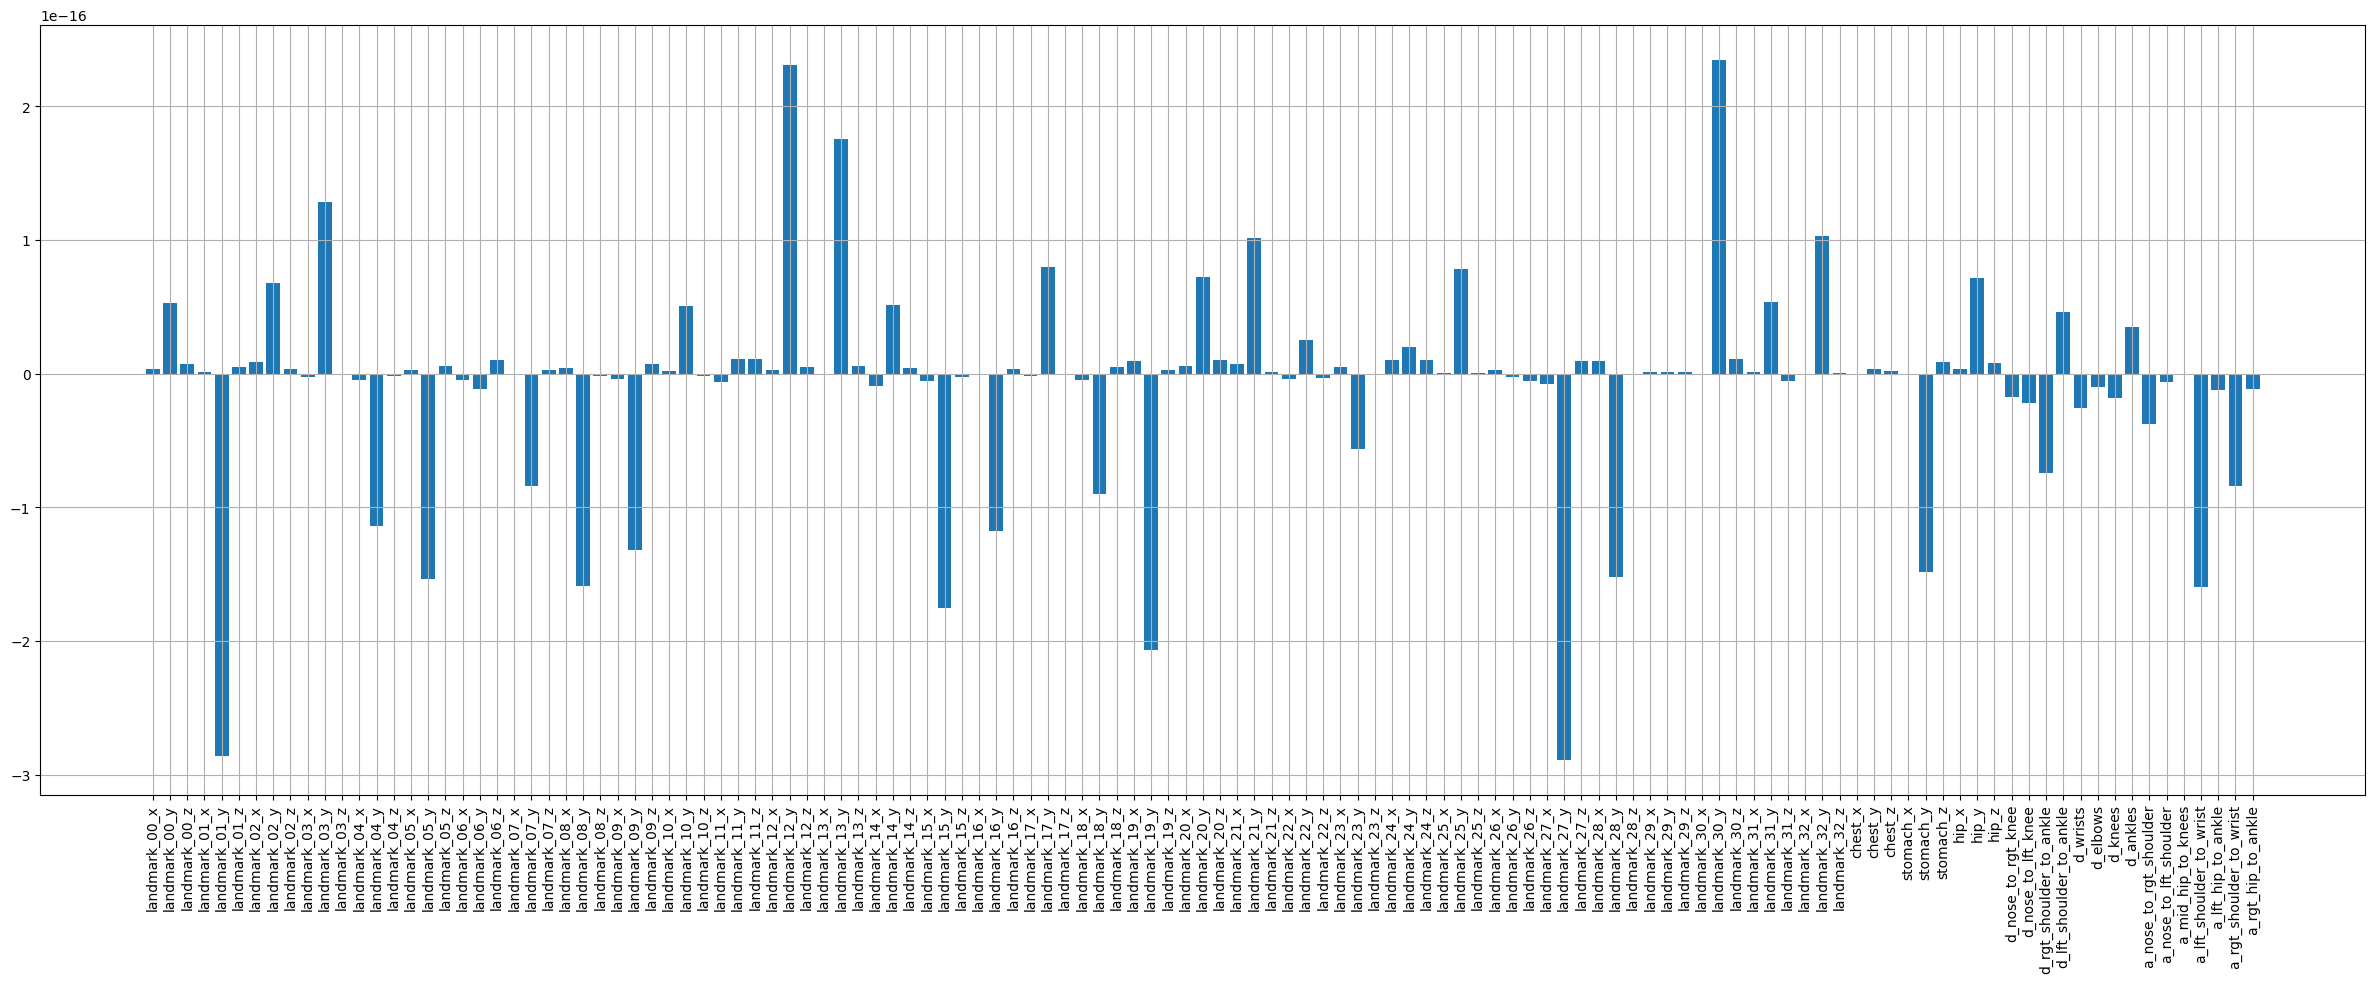

In [53]:
from sklearn.linear_model import LogisticRegression

importances = pd.DataFrame(index=feature_names)

model = LogisticRegression(max_iter=5)
model.fit(X, y)
importances = np.mean(model.coef_, axis=0)

fig, ax = plt.subplots(figsize=(30, 10))
ax.bar(feature_names, importances)
ax.set_xticks(range(len(feature_names)))
ax.set_xticklabels(feature_names, rotation=90)
ax.grid(True) 
plt.show()

## 2.2.2 Decision Trees

### Gini Impurity 

In Decision Trees using Gini impurity, weights with higher values show a greater contribution to reducing uncertainty in classifying data by effectively splitting the dataset into purer nodes.

/var/folders/8q/psx_9spx6sn4p06701_g30nh0000gn/T/ipykernel_40024/3592944640.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(feature_names, rotation=90)


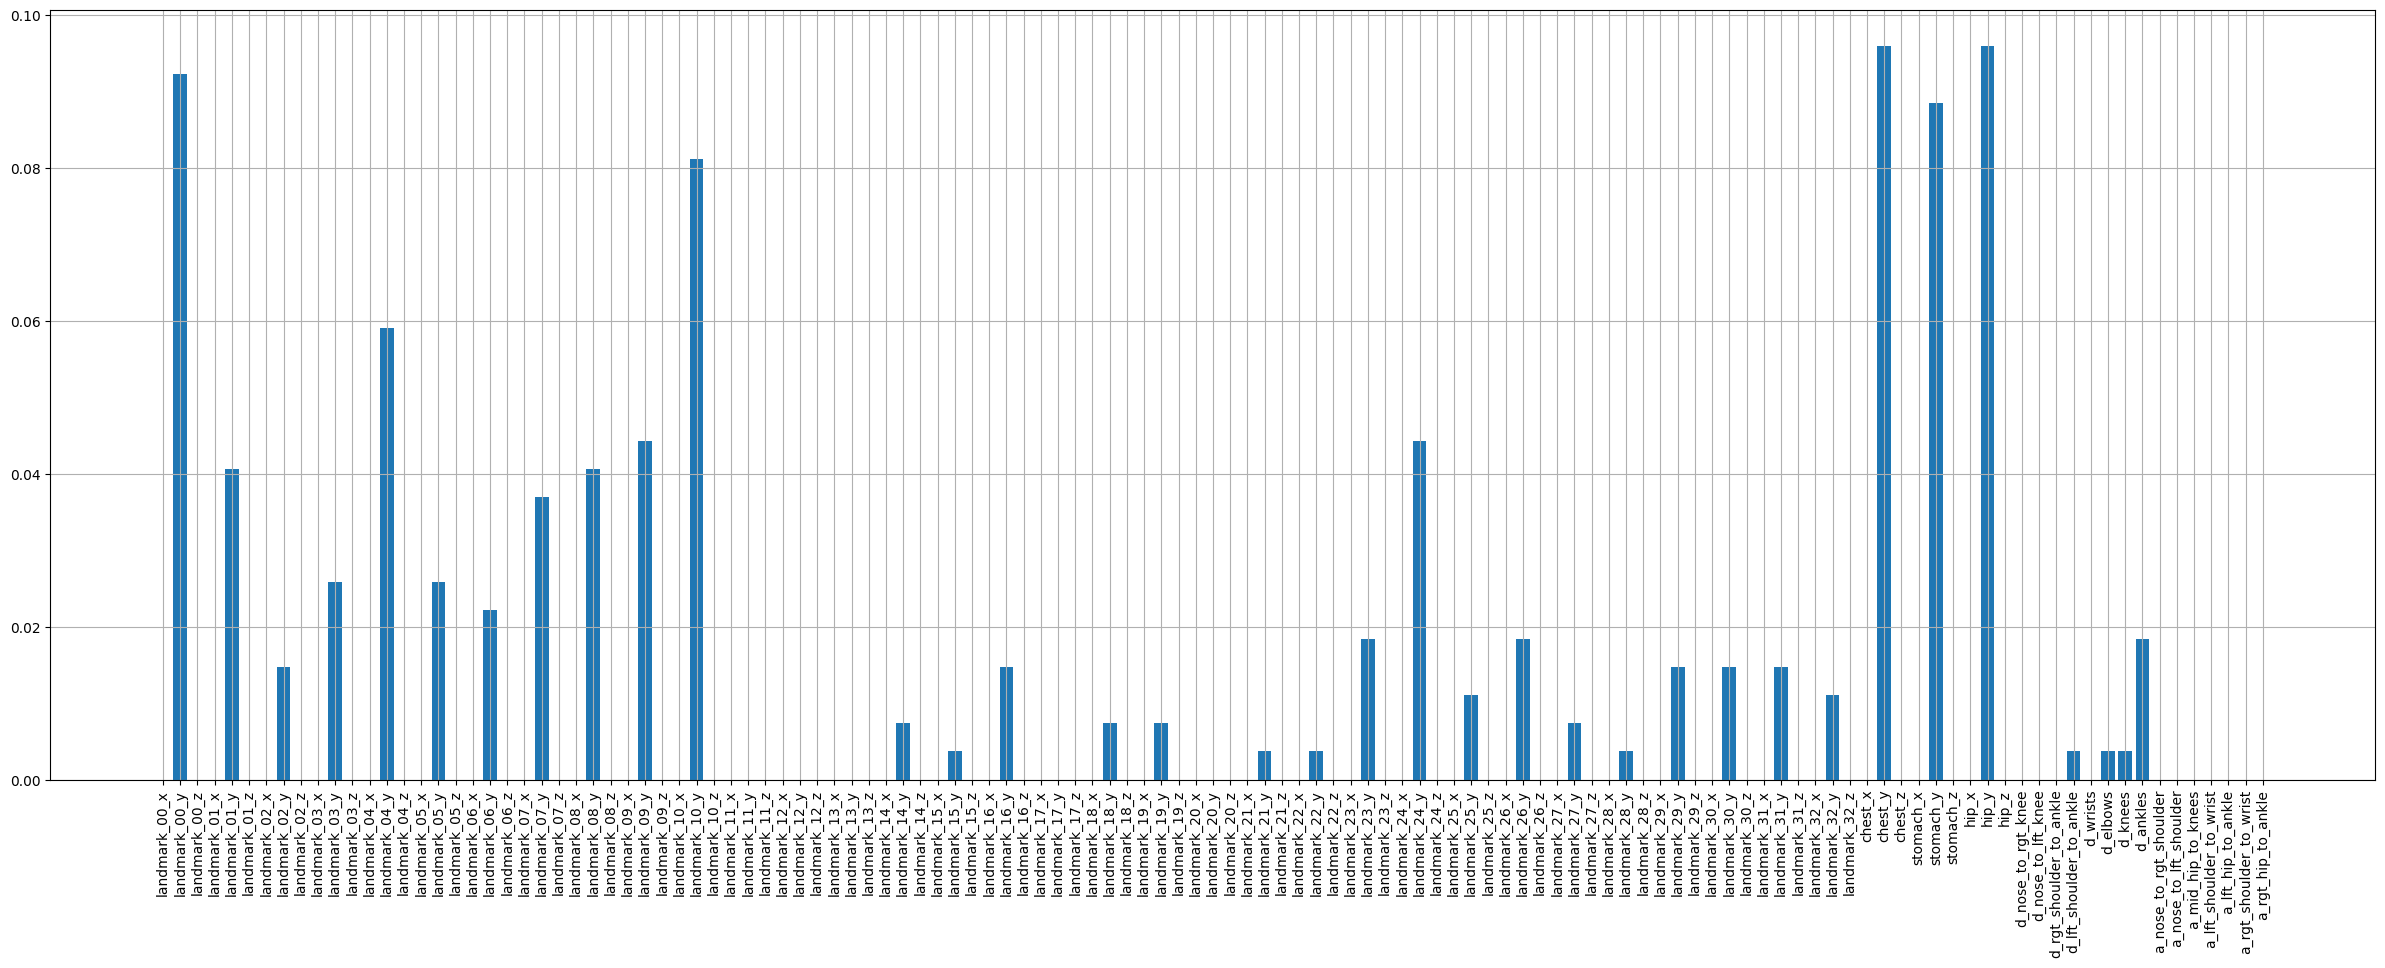

In [56]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion='gini')
model.fit(X, y)
importances = model.feature_importances_

fig, ax = plt.subplots(figsize=(30, 10))
ax.bar(feature_names, importances)
ax.set_xticks(range(len(feature_names)))
ax.set_xticklabels(feature_names, rotation=90)
ax.grid(True) 
plt.show()

## Entropy

For Decision Trees using entropy, weights with higher values indicate a feature's effectiveness in reducing classification uncertainty by splitting the dataset to maximize information gain, similar to minimizing log_loss in model evaluation by quantifying the purity of node divisions.

/var/folders/8q/psx_9spx6sn4p06701_g30nh0000gn/T/ipykernel_40024/1089194227.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(feature_names, rotation=90)


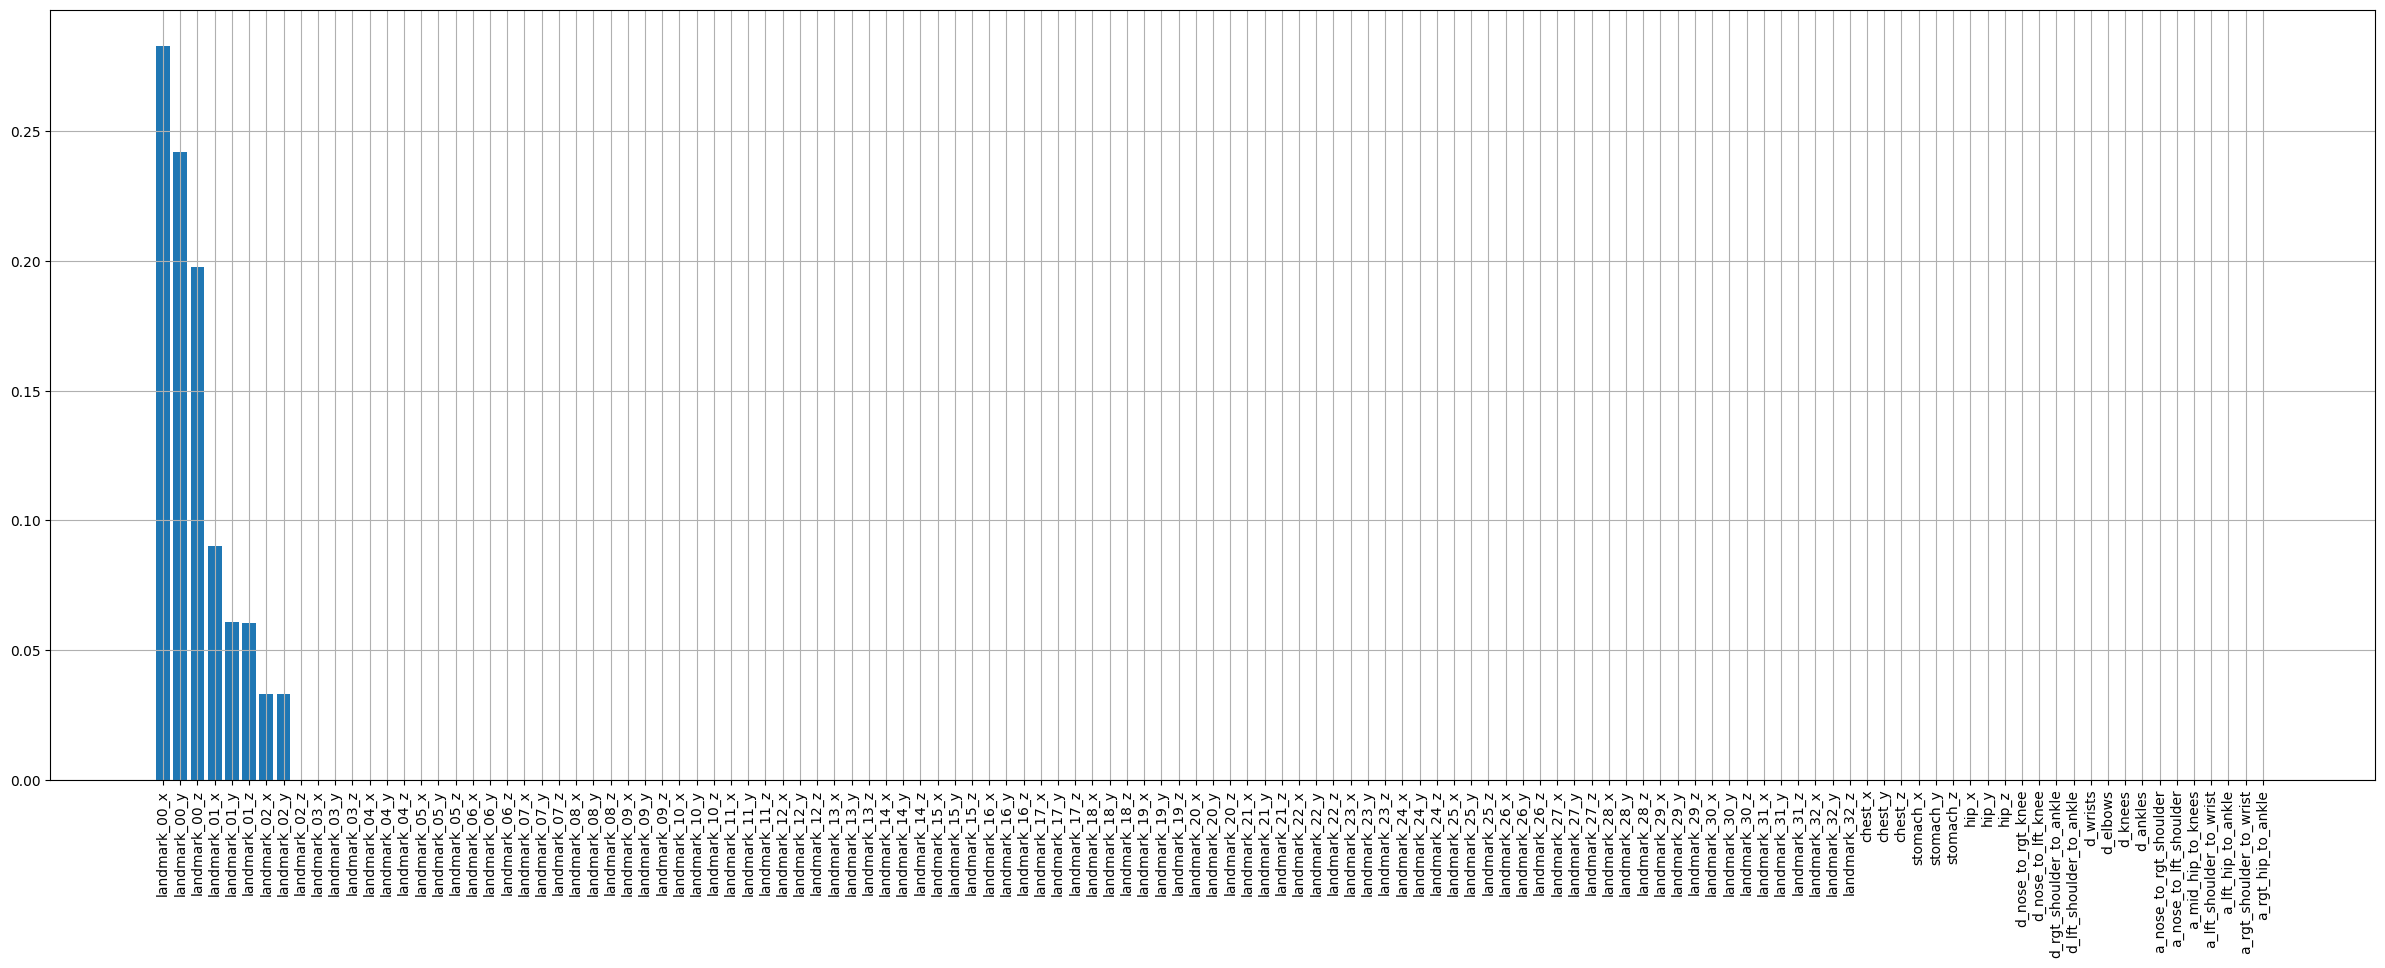

In [13]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion='entropy')
model.fit(X, y)
importances = model.feature_importances_

fig, ax = plt.subplots(figsize=(30, 10))
ax.bar(feature_names, importances)
ax.set_xticks(range(len(feature_names)))
ax.set_xticklabels(feature_names, rotation=90)
ax.grid(True) 
plt.show()

### Random Forest

Random Forest is made up of many decision trees, where each tree gives its own feature importance scores based on how much each feature decreases impurity (using entropy or Gini impurity). The forest then averages these scores across all trees to determine the overall feature importances. Higher values indicate features that consistently and significantly reduce uncertainty across multiple trees.

/var/folders/8q/psx_9spx6sn4p06701_g30nh0000gn/T/ipykernel_40024/2521823507.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(feature_names, rotation=90)


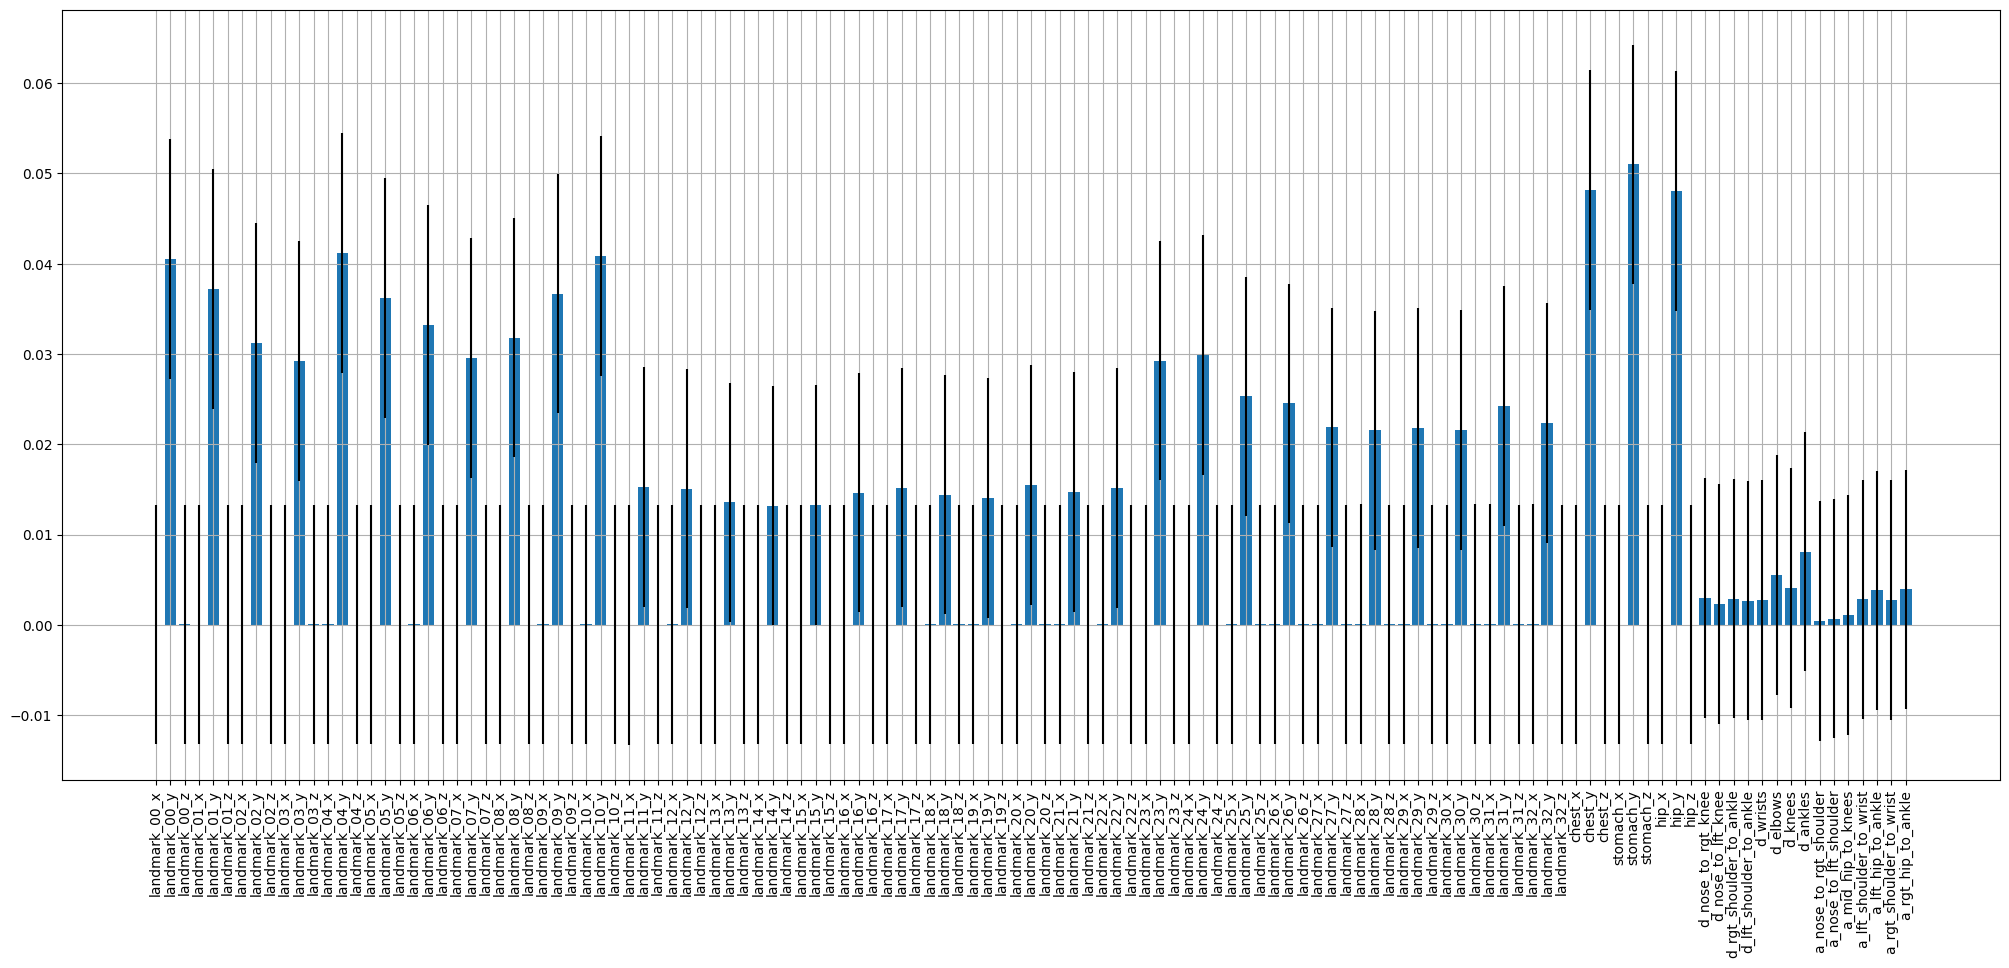

In [62]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X, y)
importances = model.feature_importances_
importances_std = np.std(importances, axis=0)

fig, ax = plt.subplots(figsize=(25, 10))
ax.bar(feature_names, importances, yerr=importances_std, align='center')
ax.set_xticklabels(feature_names, rotation=90)
ax.grid(True)
plt.show()

### XGBoost Gradient Boosting

XGBoost uses gradient boosting to create a series of decision trees, where each new tree aims to correct the errors of the previous ones. Feature importance in XGBoost is calculated based on how often a feature is used across all trees and how much it contributes to reducing the loss function, which in most cases is akin to a form of log loss.

/var/folders/8q/psx_9spx6sn4p06701_g30nh0000gn/T/ipykernel_40024/1297441079.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(feature_names, rotation=90)


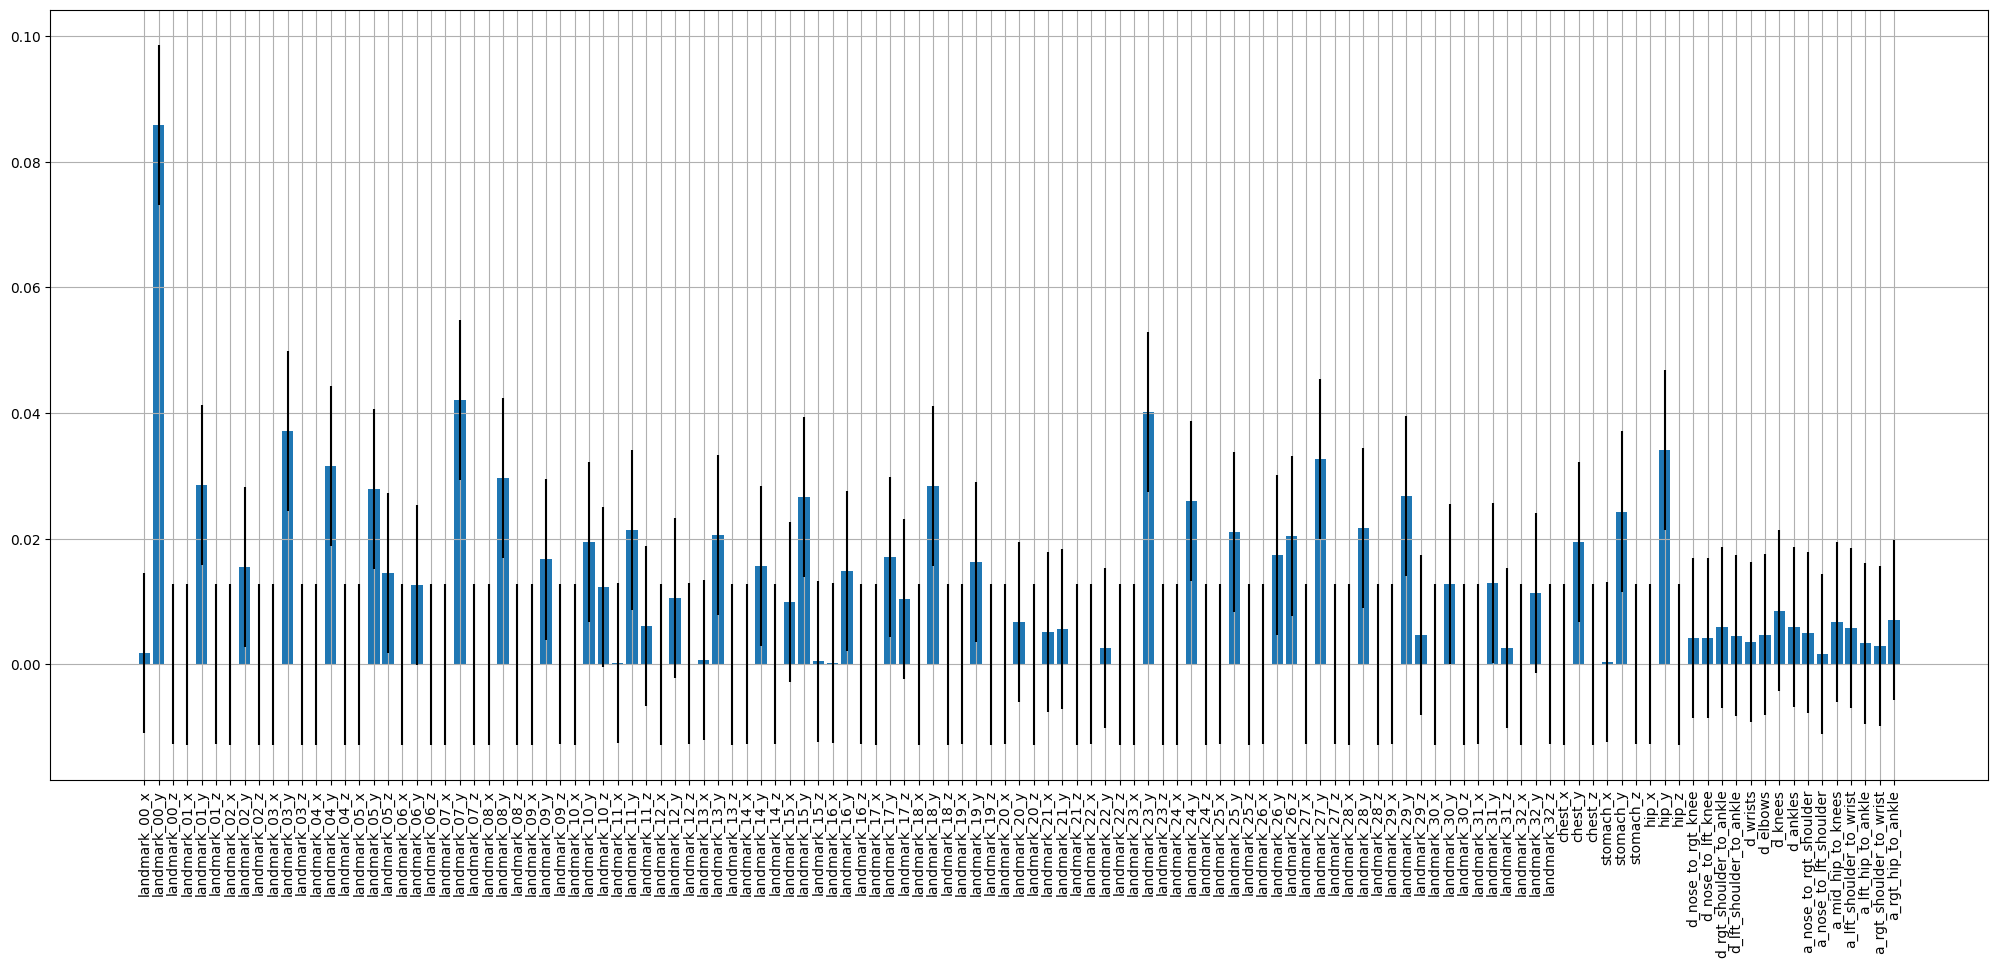

In [61]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X, y)

importances = model.feature_importances_
importances_std = np.std(importances, axis=0)

fig, ax = plt.subplots(figsize=(25, 10))
ax.bar(feature_names, importances, yerr=importances_std, align='center')
ax.set_xticklabels(feature_names, rotation=90)
ax.grid(True)
plt.show()

## 2.2.3 Permutation Importance

Weights derived from permutation feature importance represent how much the model's prediction accuracy relies on each feature. The more the accuracy decreases when a feature's values are shuffled, the more important that feature is deemed to be.

/var/folders/8q/psx_9spx6sn4p06701_g30nh0000gn/T/ipykernel_40024/3131120356.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(feature_names, rotation=90)


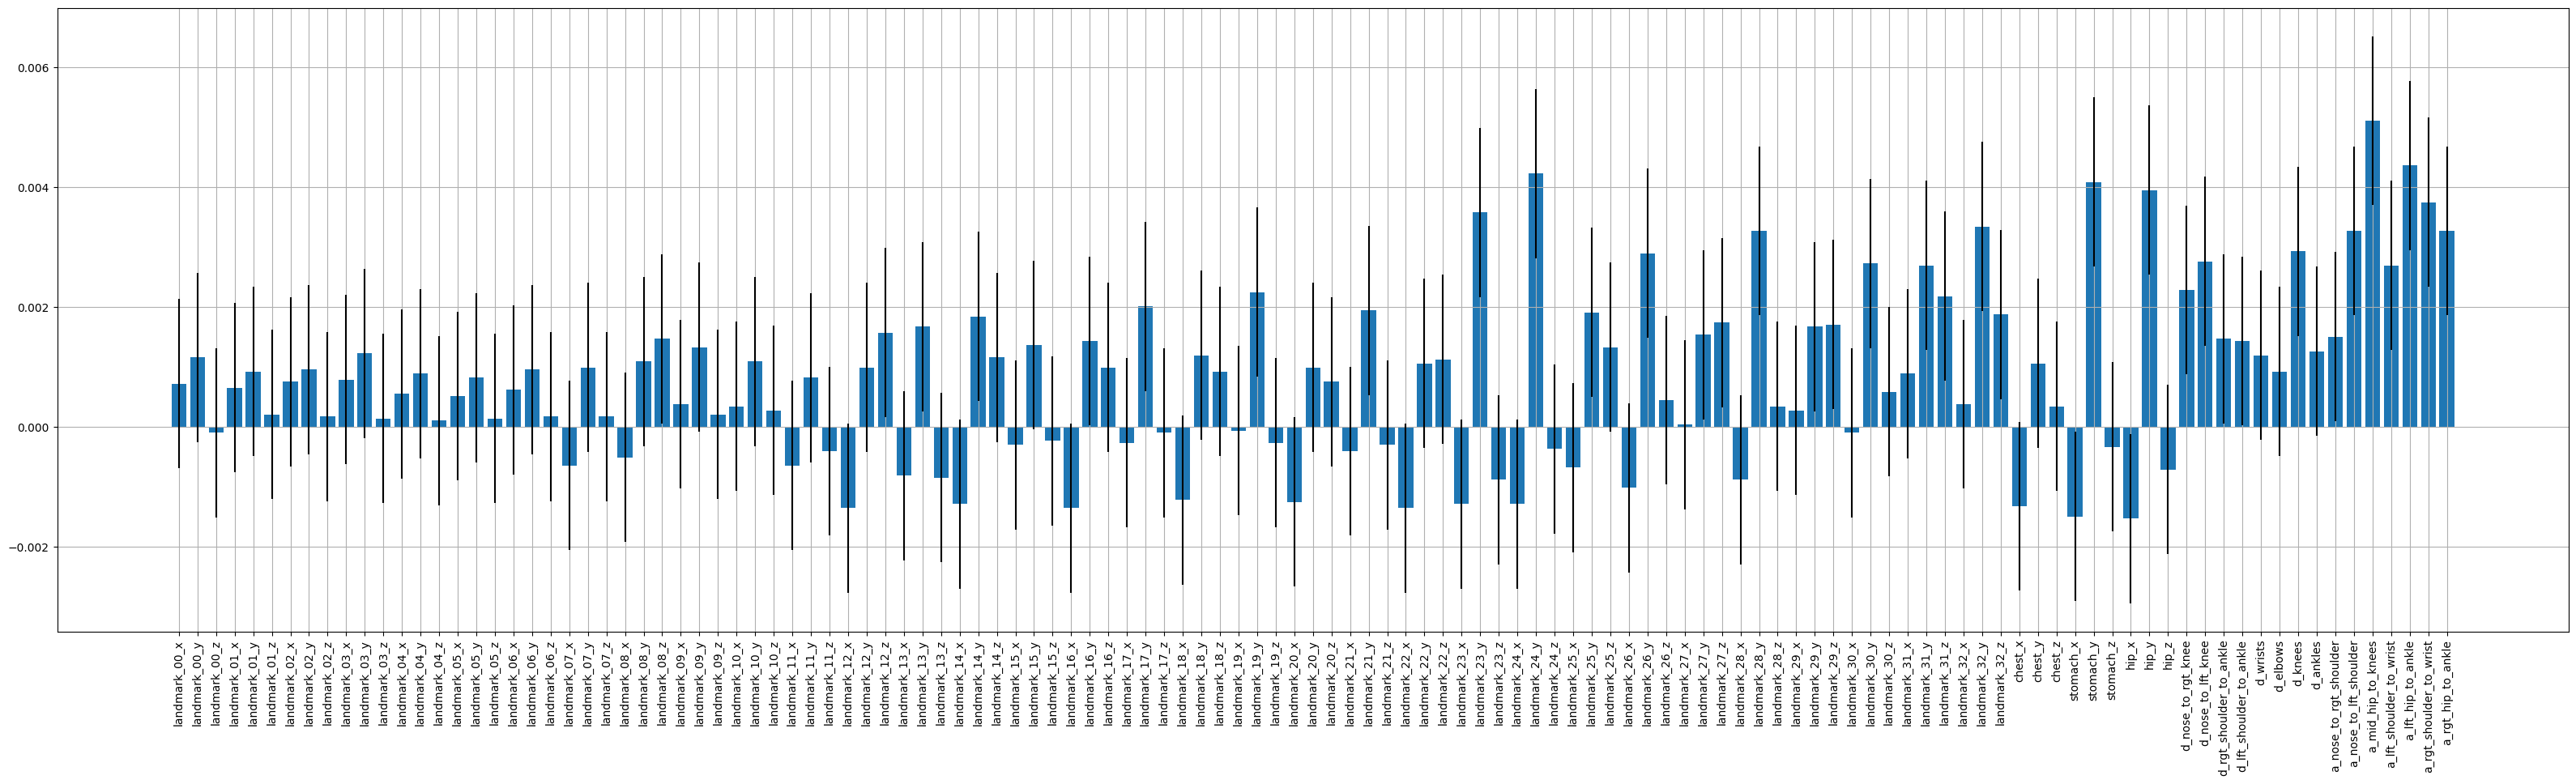

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

model = KNeighborsClassifier()
Xs, _, ys, _ = train_test_split(X, y, stratify=y, test_size=0.5, random_state=42)
model.fit(Xs, ys)

results = permutation_importance(model, Xs, ys, scoring='accuracy', n_repeats=3, n_jobs=1)
importances = results.importances_mean
importances_std = np.std(importances, axis=0)
feature_names = all_features.columns

fig, ax = plt.subplots(figsize=(40, 10))
ax.bar(feature_names, importances, yerr=importances_std, align='center')
ax.set_xticklabels(feature_names, rotation=90)
ax.grid(True)
plt.show()

## 2.2.4 Mutual Information

Mutual Information measures the amount of information obtained about one random variable through another. In the context of feature selection for classification tasks, it quantifies how much information about the target variable (class labels) is contained within a feature. Higher mutual information values indicate a higher relevance of the feature to the target variable.

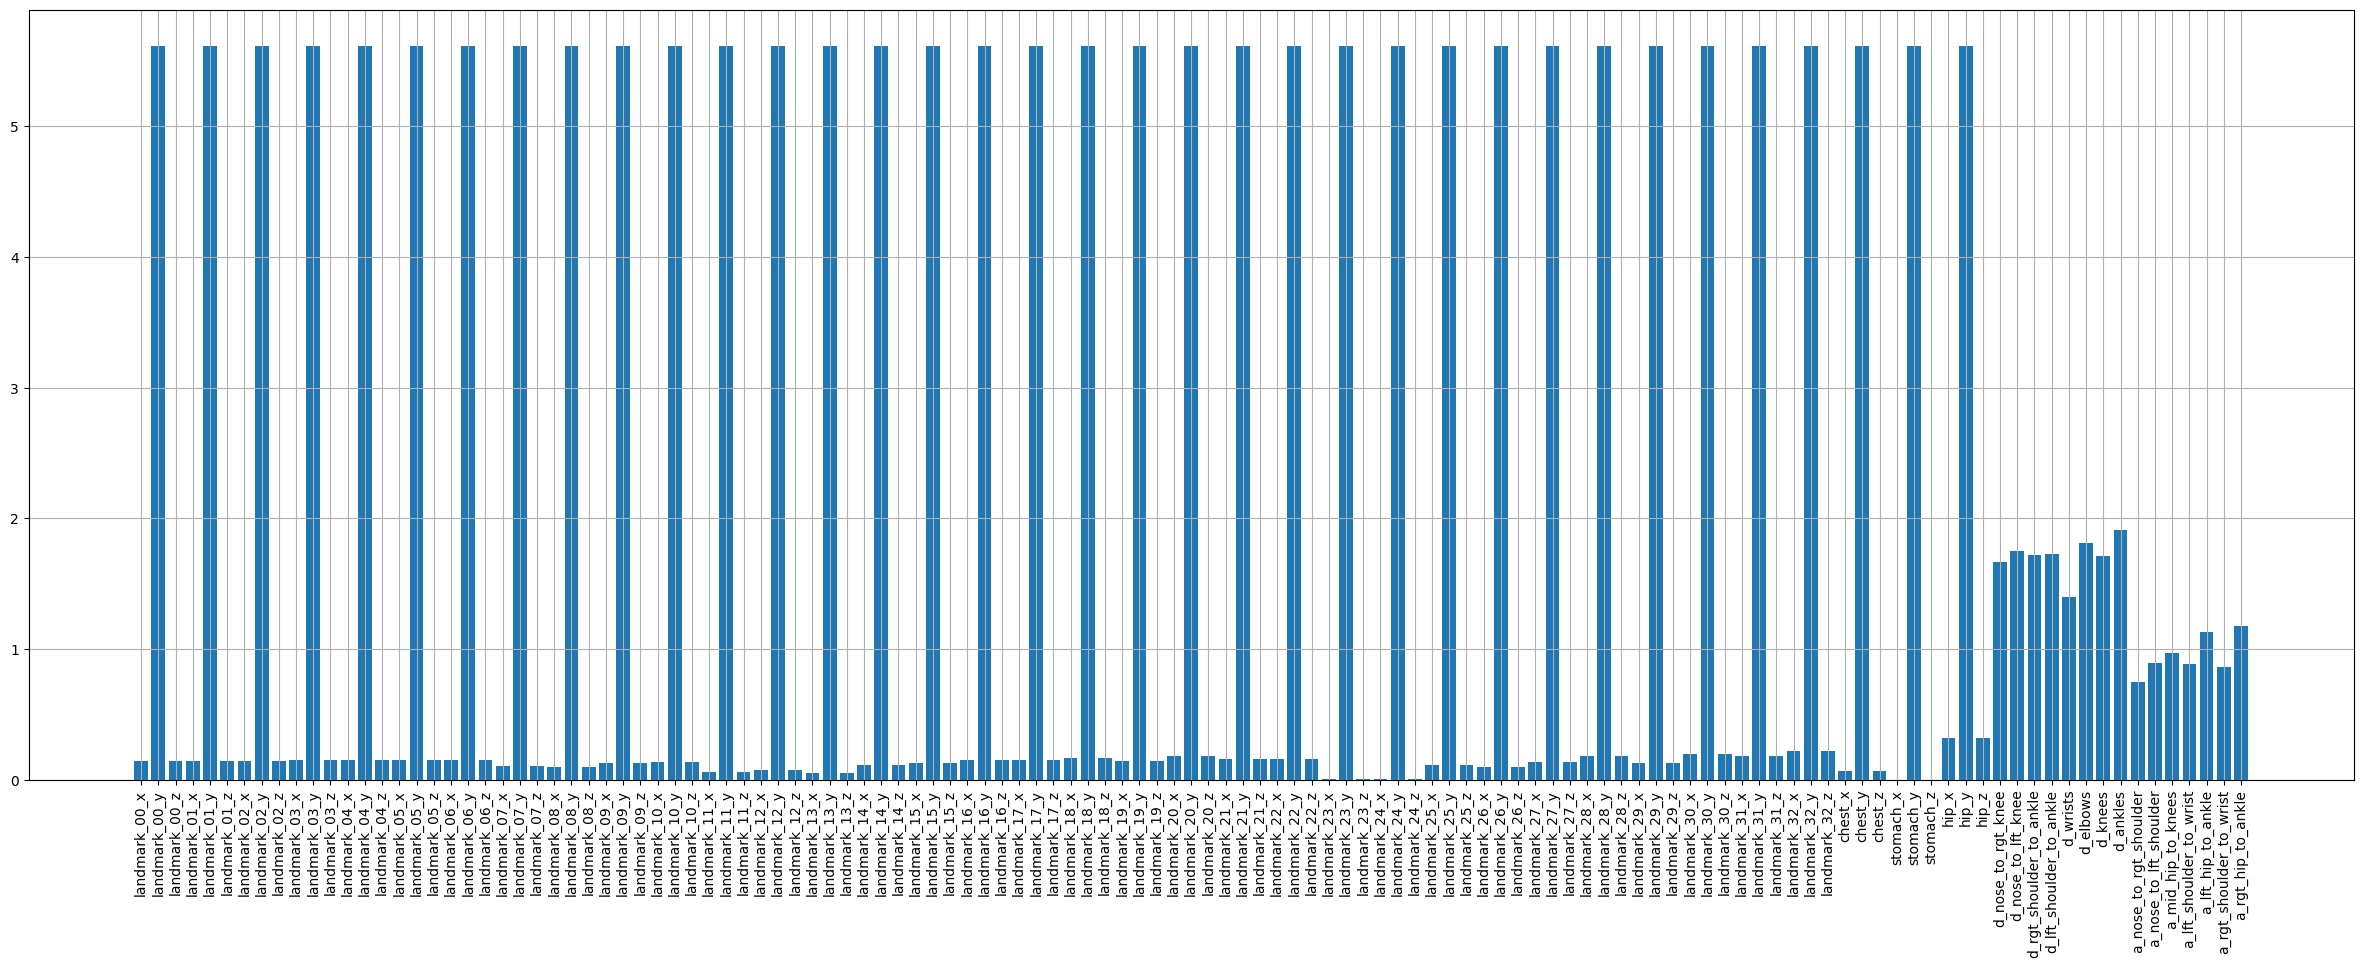

123


In [65]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X, y)

fig, ax = plt.subplots(figsize=(30, 10))
ax.bar(feature_names, importances)
ax.set_xticks(range(len(feature_names)))
ax.set_xticklabels(feature_names, rotation=90)
ax.grid(True) 
plt.show()

print(len(importances))

## Batch Implementation

In [69]:
import logging

def get_dataset(source):
    data = pd.read_csv(source)
    all_features = data.iloc[:, 5:]
    scaler = StandardScaler()
    X = scaler.fit_transform(all_features)
    y = data['label_encoded'].values
    feature_names = all_features.columns
    return X, y, feature_names

def get_feature_importances(X, y, feature_names):
    importances = pd.DataFrame(index=feature_names)
    
    model1 = LogisticRegression(max_iter=50)
    model1.fit(X,y)
    importances['logr'] = np.mean(model1.coef_, axis=0)
    print("LogisticRegression done!")

    model2 = DecisionTreeClassifier(criterion='gini')
    model2.fit(X,y)
    importances['gini'] = model2.feature_importances_
    print("DecisionTreeClassifier Gini done!")

    model3 = DecisionTreeClassifier(criterion='entropy')
    model3.fit(X,y)
    importances['entropy'] = model3.feature_importances_
    print("DecisionTreeClassifier Entropy done!")

    model4 = RandomForestClassifier()
    model4.fit(X, y)
    importances['rfc'] = model4.feature_importances_
    print("DecisionTree RFC done!")

    model5 = XGBClassifier()
    model5.fit(X, y)
    importances['xgb'] = model5.feature_importances_
    print("XGBClassifier done!")

    model6 = KNeighborsClassifier()
    model6.fit(X, y)
    results = permutation_importance(model6, X, y, scoring='accuracy')
    importances['permutation'] = results.importances_mean
    print("Permutation Importance done!")

    mutual_information = mutual_info_classif(X, y)
    importances['mutual_info'] = mutual_information
    print("Mutual Information collected!")
    
    return importances

X, y, feature_names = get_dataset("dataset/pose_data_augmented_res.csv")
feature_weights = get_feature_importances(X, y, feature_names)
feature_weights

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression done!
DecisionTreeClassifier Gini done!
DecisionTreeClassifier Entropy done!
DecisionTree RFC done!
XGBClassifier done!
Permutation Importance done!
Mutual Information collected!


,logr,gini,entropy,rfc,xgb,permutation,mutual_info
landmark_00_x,6.762870e-17,0.000000,0.000000,0.000042,0.001861,0.000000,0.144656
landmark_00_y,6.477662e-16,0.070111,0.203993,0.043842,0.085898,0.000000,5.612737
landmark_00_z,-1.566353e-17,0.000000,0.000000,0.000069,0.000022,0.000031,0.144656
landmark_01_x,6.681236e-17,0.000000,0.000000,0.000016,0.000000,0.000000,0.144137
landmark_01_y,-1.632681e-17,0.029520,0.044038,0.036962,0.028613,0.000000,5.612737
...,...,...,...,...,...,...,...
a_mid_hip_to_knees,7.091958e-17,0.000000,0.000000,0.001443,0.006763,0.001328,0.966895
a_lft_shoulder_to_wrist,-6.449090e-17,0.003690,0.000000,0.002822,0.005821,0.000000,0.887514
a_lft_hip_to_ankle,-3.914353e-16,0.000000,0.000000,0.003524,0.003342,0.000807,1.132453
a_rgt_shoulder_to_wrist,1.100019e-16,0.003690,0.000000,0.002912,0.002934,0.000082,0.862385


In [73]:
feature_weights.to_csv("feature_weights_no_index.csv", index=False)

# Resources

1. https://machinelearningmastery.com/calculate-feature-importance-with-python/
2. https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/